In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import mlflow
import dagshub
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dagshub.init(repo_owner='chandu1613',
             repo_name='MLProject',
             mlflow=True)

Accessing as Chandu1613

Initialized MLflow to track repo "chandu1613/MLProject"

Repository chandu1613/MLProject initialized!

In [3]:
os.environ["MLFLOW_TRACKING_USERNAME"] = "Chandu1613"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "6656b403fc3d6206838ca3affb4b3b2b84d84b8a"

In [4]:
mlflow.set_tracking_uri("https://dagshub.com/Chandu1613/MLProject.mlflow")

In [5]:
mlflow.set_experiment("Wine_Prediction_Evaluation")

<Experiment: artifact_location='mlflow-artifacts:/935d2bd6f5df4d5c844f31f11b5690b1', creation_time=1741802028140, experiment_id='1', last_update_time=1741802028140, lifecycle_stage='active', name='Wine_Prediction_Evaluation', tags={}>

In [6]:
os.chdir("../")

In [7]:
pwd

'c:\\Users\\jagad\\OneDrive\\Desktop\\MLP'

In [8]:
with open('models/trainedModel.pkl', "rb") as f:
    model = pickle.load(f)
print("Model loaded successfully!")

Model loaded successfully!


In [9]:
test_data = pd.read_csv("artifacts/test.csv")
X_test = test_data.drop('quality', axis=1)
y_test = test_data['quality']

print("Test data loaded successfully!")
print(f"Test data shape: {X_test.shape}")

Test data loaded successfully!
Test data shape: (340, 11)


In [10]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [11]:
type(X_test)

pandas.core.frame.DataFrame

In [12]:
print(f"Model type: {type(model)}")

Model type: <class 'sklearn.ensemble._forest.RandomForestRegressor'>


In [20]:
model

RandomForestRegressor(random_state=42)

In [14]:
y_pred = model.predict(X_test)
print("Predictions made successfully!")

Predictions made successfully!


In [15]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

MSE: 0.3922
MAE: 0.5025
R²: 0.3689


🏃 View run inquisitive-bass-993 at: https://dagshub.com/Chandu1613/MLProject.mlflow/#/experiments/1/runs/1fc8f5c7b35442d3a3121c848cadcd7f
🧪 View experiment at: https://dagshub.com/Chandu1613/MLProject.mlflow/#/experiments/1
Metrics and artifacts logged to MLflow successfully!


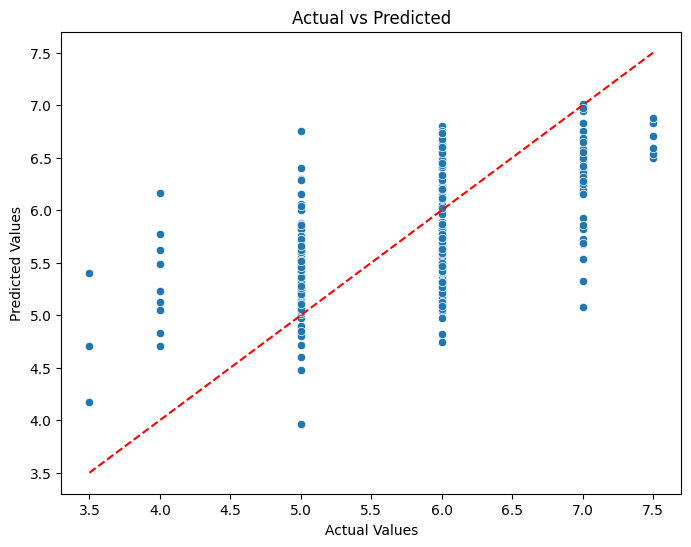

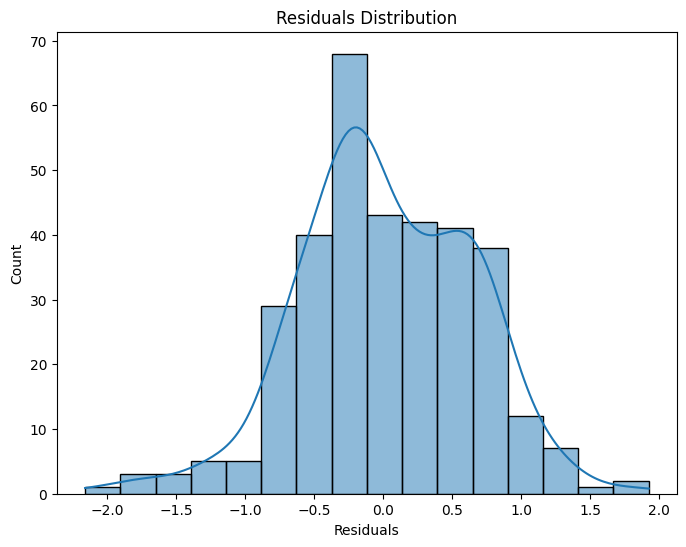

In [16]:
with mlflow.start_run():
    # Log metrics
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("R2", r2)

    # Log predictions as a CSV file
    predictions_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
    predictions_df.to_csv("predictions.csv", index=False)
    mlflow.log_artifact("predictions.csv")

    # Log visualizations
    # Actual vs Predicted Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
    plt.savefig("actual_vs_predicted.png")
    mlflow.log_artifact("actual_vs_predicted.png")

    # Residuals Distribution Plot
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True)
    plt.xlabel("Residuals")
    plt.title("Residuals Distribution")
    plt.savefig("residuals_distribution.png")
    mlflow.log_artifact("residuals_distribution.png")

print("Metrics and artifacts logged to MLflow successfully!")

In [21]:
train = pd.read_csv('artifacts/train.csv')

In [22]:
X_train = train.drop('quality',axis=1)
y_train = train['quality']

In [25]:
import joblib
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score


# Identify the model type
model_name = type(model).__name__
print(f"Loaded Model: {model_name}")
print(f"Default Hyperparameters: {model.get_params()}")

# Define hyperparameter grids
param_grids = {
    "RandomForestRegressor": {
        "n_estimators": [100, 300, 500],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False]
    },
    "GradientBoostingRegressor": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "max_depth": [3, 5, 10],
        "subsample": [0.7, 0.8, 0.9, 1.0]
    },
    "SVR": {
        "kernel": ["linear", "rbf", "poly"],
        "C": [0.1, 1, 10, 100],
        "gamma": ["scale", "auto"]
    },
    "ElasticNet": {
        "alpha": [0.01, 0.1, 0.5, 1.0, 10],
        "l1_ratio": [0.2, 0.5, 0.7, 0.9]
    },
}

# If the model is LinearRegression or Ridge, tuning is minimal
if model_name == "LinearRegression":
    print("Linear Regression has no hyperparameters to tune.")
    best_model_tuned = Ridge(alpha=1.0)
    best_model_tuned.fit(X_train, y_train)

elif model_name in param_grids:
    # Perform hyperparameter tuning using RandomizedSearchCV
    param_grid = param_grids[model_name]
    tuner = RandomizedSearchCV(
        estimator=model, param_distributions=param_grid,
        n_iter=10, cv=5, scoring="r2", n_jobs=-1, verbose=2, random_state=42
    )
    
    tuner.fit(X_train, y_train)
    best_model_tuned = tuner.best_estimator_
    print(f"Best Tuned Parameters: {best_model_tuned.get_params()}")

else:
    print("No tuning strategy defined for this model.")
    best_model_tuned = model  # Keep the original model if not tunable

# Evaluate Models (Before and After Tuning)
y_pred_before = model.predict(X_test)
y_pred_after = best_model_tuned.predict(X_test)

rmse_before = mean_squared_error(y_test, y_pred_before)
r2_before = r2_score(y_test, y_pred_before)

rmse_after = mean_squared_error(y_test, y_pred_after)
r2_after = r2_score(y_test, y_pred_after)

print(f"\n🔹 Before Tuning - RMSE: {rmse_before:.4f}, R²: {r2_before:.4f}")
print(f"🔹 After Tuning  - RMSE: {rmse_after:.4f}, R²: {r2_after:.4f}")

os.makedirs("models", exist_ok=True)
with open("models/tunedModel.pkl", "wb") as f:
    pickle.dump(best_model_tuned, f)

Loaded Model: RandomForestRegressor
Default Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Tuned Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

🔹 Before Tuning - RMSE: 0.3922, R²: 0.3689
🔹 After Tuning  -

In [3]:
import os

In [4]:
predictions_path = os.path.join('artifacts', "predictions")

In [6]:
print(predictions_path)

artifacts\predictions
